# Домашнее задание. МОМО, Соревнование Kaggle, Clustering
## 1) Импорт библиотек

In [1]:
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import pandas as pd # Библиотека Pandas для работы с табличными данными

import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import matplotlib as mpl
import seaborn as sns # библиотека Seaborn для визуализации данных из Pandas
import plotly.express as px

from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture # EM-Кластеризация со смесью Гауссиан  от Scikit-learn

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('dark_background') # для установики темного фона графиков

## 2) Набор данных

В качестве домашнего задания предлагается решить задачу предсказания степени загрязненности воды [kaggle](https://www.kaggle.com/competitions/urfusf2024clustering/)

Данные можно скачать со страницы [соревнования](https://www.kaggle.com/competitions/urfusf2024clustering/data)

In [3]:
# Подгрузим данные в pandas dataframe
data = pd.read_csv('./data/Data.csv')

## 3) Exploratory Data Analysis (EDA)

In [4]:
# Посмотрим краткую информацию по датасету
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19033 entries, 0 to 19032
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   idx        19033 non-null  int64  
 1   Признак 1  19033 non-null  float64
 2   Признак 2  19033 non-null  float64
 3   Признак 3  19033 non-null  float64
 4   Признак 4  19033 non-null  float64
 5   Признак 5  19033 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 892.3 KB


In [5]:
# Удалим незначащий столбец idx
data.drop('idx', axis=1, inplace=True)

In [6]:
# Стандартные характеристики датасета
data.describe()

,Признак 1,Признак 2,Признак 3,Признак 4,Признак 5
count,1.903300e+04,1.903300e+04,1.903300e+04,1.903300e+04,1.903300e+04
mean,1.009525e-16,5.818533e-17,-7.792721e-17,2.990801e-16,4.720511e-17
std,5.372720e-01,6.612815e-02,6.395875e-02,4.809839e-01,5.676626e-02
min,-8.865561e-01,-4.705258e-02,-3.499009e-01,-5.417184e-01,-3.695438e-01
25%,-2.556412e-01,-1.392043e-02,-2.251187e-02,-4.636834e-01,-1.943088e-02
50%,-1.527072e-01,-9.348055e-03,3.760155e-03,-1.193854e-01,2.740698e-03
75%,1.387202e-01,-5.841646e-03,2.707801e-02,3.591970e-01,2.958351e-02
max,1.048308e+00,9.805234e-01,3.976242e-01,1.067578e+00,4.547306e-01


In [7]:
# Просмотр уникальных значений по колонкам
for col in data.columns:
    print(f"Number of unique values of '{col}' = {data[col].nunique()}")

Number of unique values of 'Признак 1' = 19033
Number of unique values of 'Признак 2' = 19033
Number of unique values of 'Признак 3' = 19033
Number of unique values of 'Признак 4' = 19033
Number of unique values of 'Признак 5' = 19033


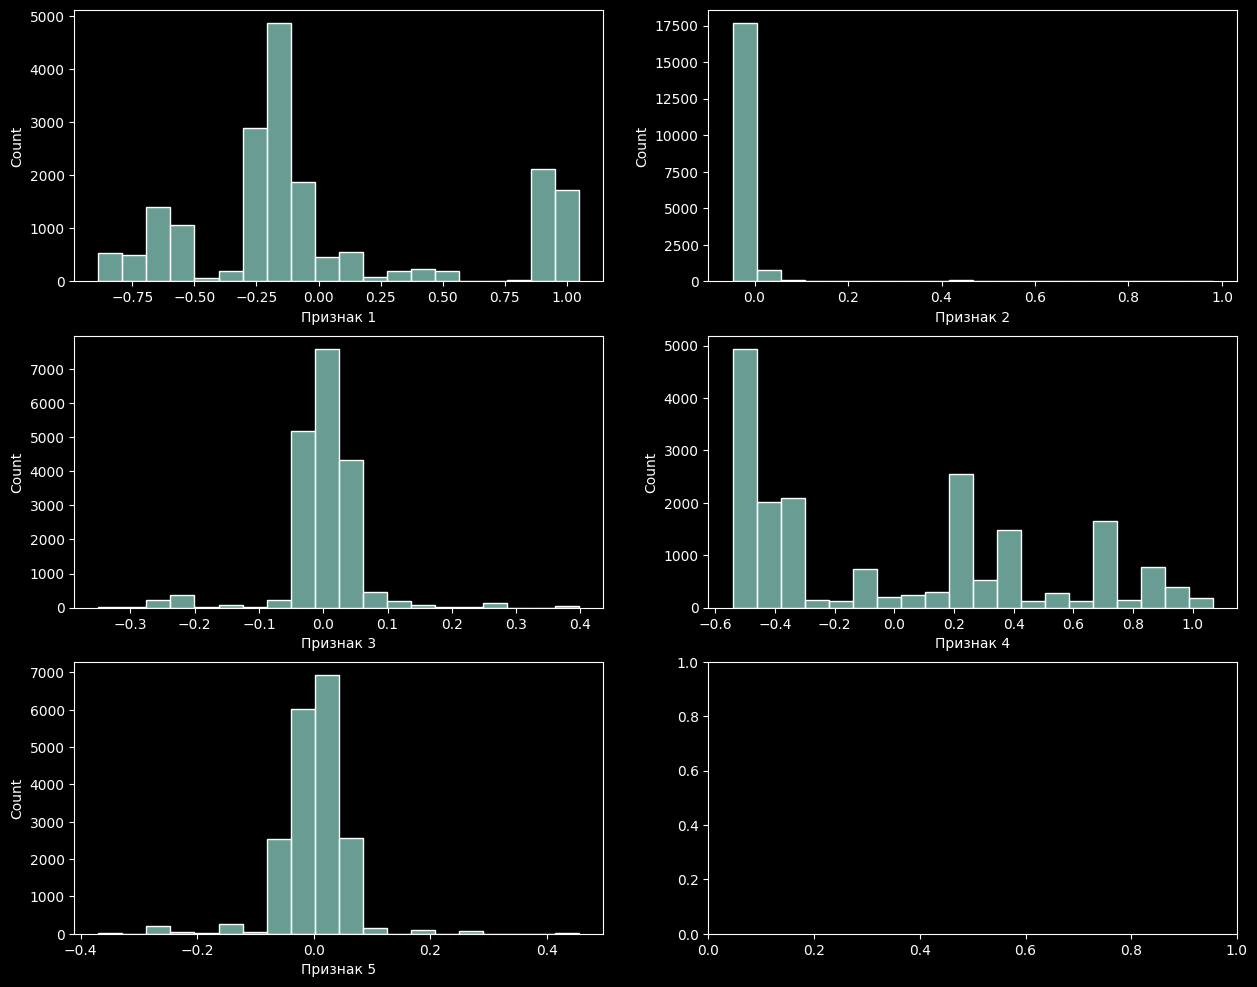

In [8]:
# Построим графики признаков
width = 2

height = int(np.ceil(data.shape[1] / width))
fig, ax = plt.subplots(nrows=height, ncols=width, figsize=(15, 12)) # создаем "полотно", на котором будем "рисовать" графики
#     ↑  более точная структура (почти синоним subplot). Говорим что у нас будет height строк и width столбцов

for idx, column_name in enumerate(data.columns): # перебираем все числовые данные
    plt.subplot(height, width, idx + 1) # берем конкретную ячейку из заранее подготовленную заготовки
    # рисуем с помощью библиотеки seaborn
    sns.histplot(data=data, x=column_name, bins = 20); 

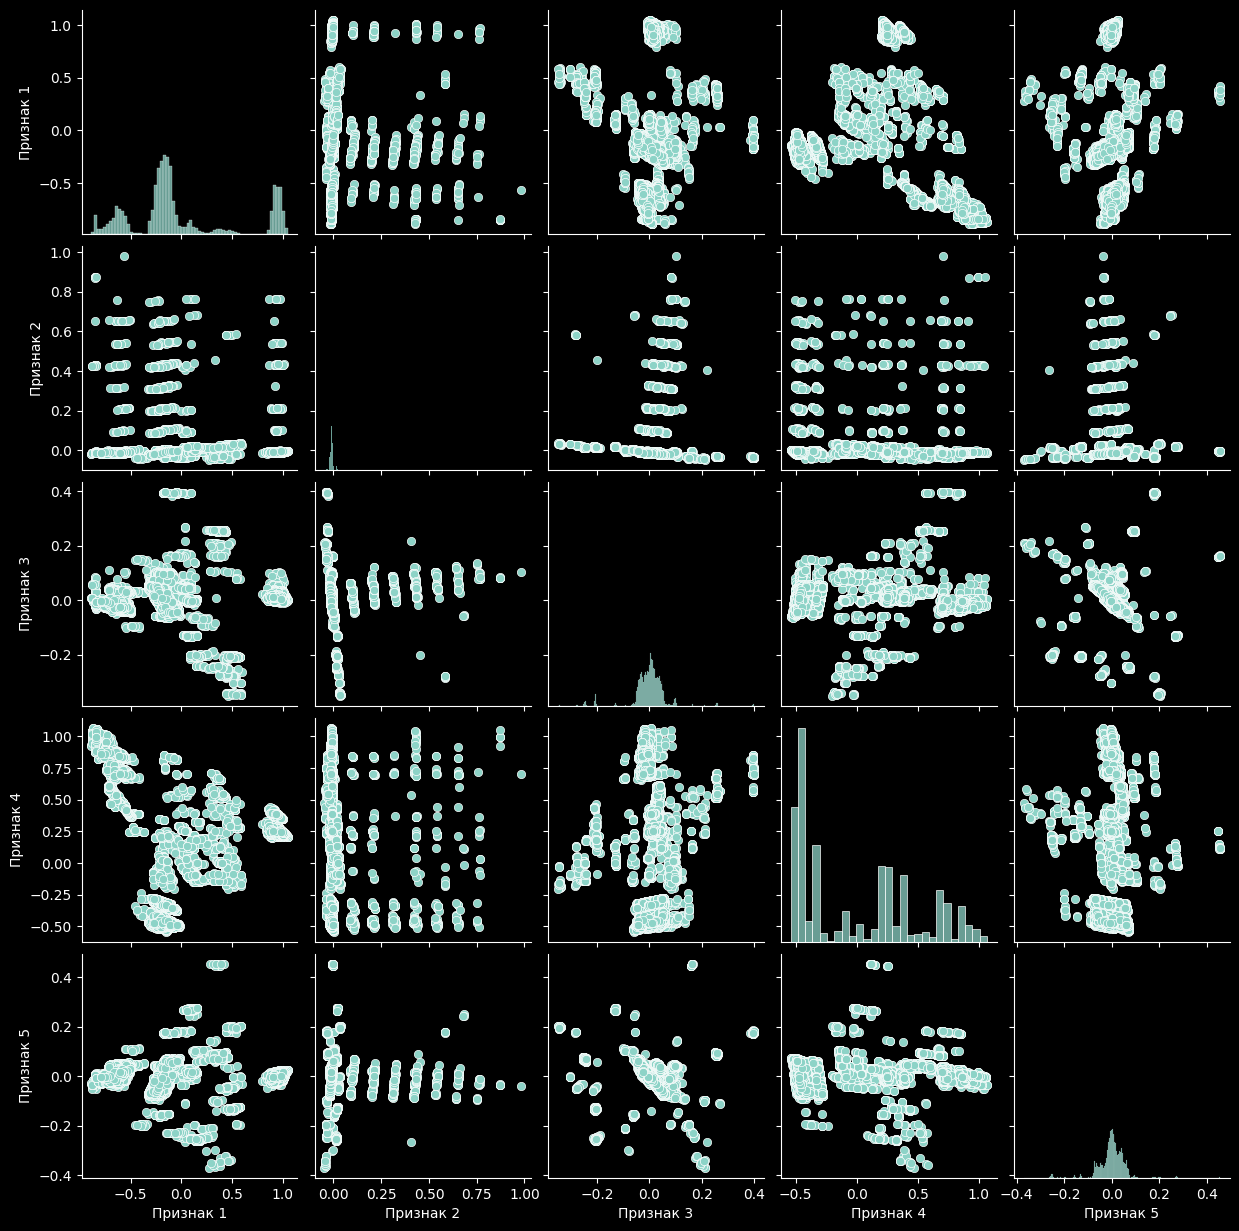

In [9]:
# Просмотр графиков pairplot
sns.pairplot(data)

### 3.1 Визуализация t-SNE

In [10]:
# Весь датасет слишком большой, возьмем из него только часть
X_part = data.values[:3000]

In [11]:
n_iter = 1000 
perplexity = 35 

tsne = TSNE(n_components=2, verbose=1,
            perplexity=perplexity, n_iter=n_iter,
            learning_rate = 'auto', init = 'pca')
tsne_results = tsne.fit_transform(X_part)

[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.006s...
[t-SNE] Computed neighbors for 3000 samples in 0.057s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.011044
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.892429
[t-SNE] KL divergence after 1000 iterations: 0.264887


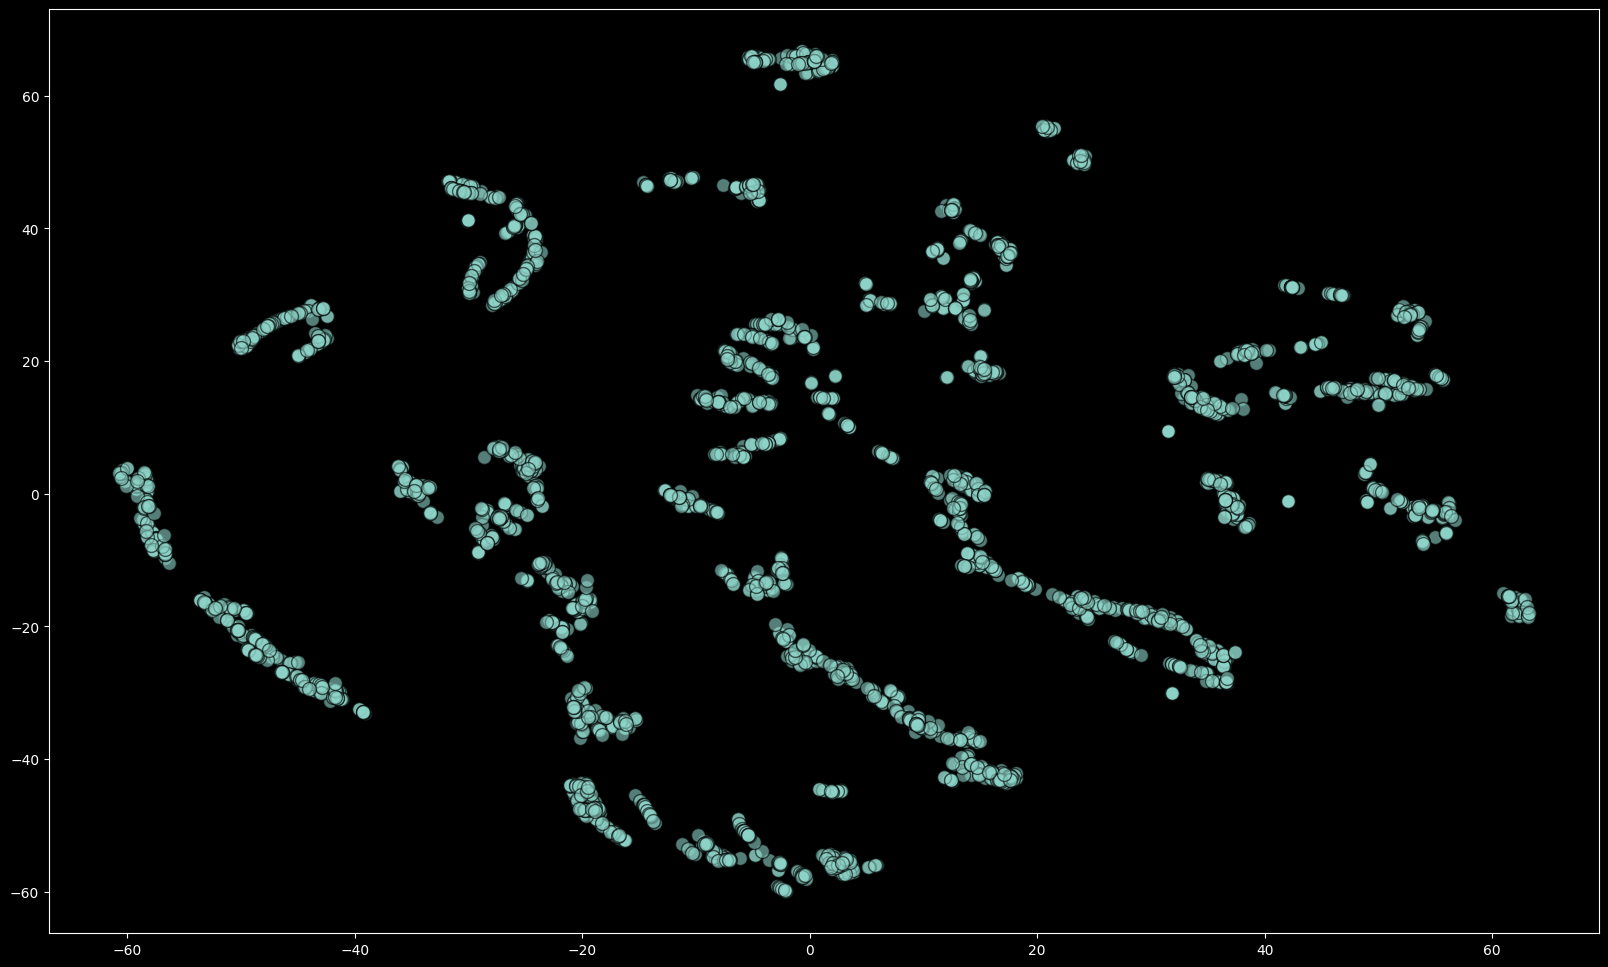

In [12]:
fig= plt.figure(figsize=(20,12))
ax = plt.subplot(1, 1, 1)
ax.scatter(tsne_results[:, 0], tsne_results[:, 1], # данные
                    alpha = 0.6, # прозрачность
                    cmap = 'bwr', # тип цветовой карты
                    edgecolor = 'k', # цвет края - черный
                    s = 100  # размер
                    )

## 4. Кластеризация

### 4.1. EM-кластеризация

In [13]:
# Создаем Класс ЕМ-Кластеризации со смесью моделей Гауссиан
gm = GaussianMixture(n_components=5, covariance_type = 'full', random_state=42)

In [14]:
# Обучаем модель
gm.fit(data)

GaussianMixture(n_components=5, random_state=42)

In [15]:
# Получаем метки кластеров предстказанные моделью
labels = gm.predict(data)

## 5. Submission

In [16]:
# Подгрузим submission в pandas dataframe
submission = pd.read_csv('./data/Submission.csv')

In [17]:
# Проверим этот датасет
submission.head()

,idx,label
0,0,2
1,1,0
2,2,0
3,3,0
4,4,1


In [18]:
# Посмотрим на распределение и количество кластеров
submission['label'].value_counts()

0    9473
2    8224
4     765
1     300
3     271
Name: label, dtype: int64

In [19]:
# Функция трансформирующая метки по количеству
def transform_labels(labels):
    cluster_sizes = np.bincount(labels)
    new_order = np.argsort(cluster_sizes)[::-1]
    label_map = {labels: new_label for new_label, labels in enumerate(new_order)}
    new_labels = np.array([label_map[label] for label in labels])
    return new_labels

In [20]:
# Присвоение новой метки к данным для загрузки в kaggle
submission['label'] = transform_labels(labels)

In [21]:
# Посмотрим на распределение и количество кластеров после преобразования
submission['label'].value_counts()

0    9198
1    3865
2    3560
3    2135
4     275
Name: label, dtype: int64

In [22]:
# Выгружаем в файл
submission.to_csv('./data/cluster_prediction.csv', columns=['idx', 'label'], index=False)

**Выводы:**
1. Применение преобразователей StandardScaler и PowerTransformer ухудшали метрику F1 на kaggle
2. Другие модели кластеризации (спектральная, иерархическая) показывали результат хуже.
3. Визуализация t-SNE показала, что не получается разбить датасет на явные кластеры